# Applied Data Analysis Project
**Team**: ToeStewBrr - Alexander Sternfeld, Marguerite Thery, Antoine Bonnet, Hugo Bordereaux

**Dataset**: CMU Movie Summary Corpus


In [1]:
import requests
import tarfile
import urllib
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as plt
import re
import gzip

## 1. Loading data

We first extract all files from the [MoviesSummaries dataset](http://www.cs.cmu.edu/~ark/personas/). 

In [2]:
if not os.path.exists('Data/MovieSummaries'):
    filename = 'http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz'
    my_tar = tarfile.open(fileobj=urllib.request.urlopen(filename), mode="r:gz") 
    my_tar.extractall('./Data') # specify which folder to extract to
    my_tar.close()

Note: Extraction of CoreNLP files takes 15min42s, while conversion takes 33s. 

In [ ]:
# Extract all coreNLP files to Data/CoreNLP
if not os.path.exists('Data/CoreNLP'):
    coreNLPfilename = 'http://www.cs.cmu.edu/~ark/personas/data/corenlp_plot_summaries.tar'
    my_tar = tarfile.open(fileobj=urllib.request.urlopen(coreNLPfilename), mode="r|") 
    my_tar.extractall(path='./Data/CoreNLP') # specify which folder to extract to
    my_tar.close()

# Convert every file in directory Data/CoreNLP to xml format
raw_dir = 'Data/CoreNLP/corenlp_plot_summaries'
extracted_dir = 'Data/CoreNLP/corenlp_plot_summaries_xml'
if not os.path.exists(extracted_dir):
    os.mkdir(extracted_dir)
    for filename in os.listdir(raw_dir):
        f = os.path.join(raw_dir, filename) 
        if os.path.isfile(f):
            # Open and store file as xml 
            with gzip.open(f, 'rb') as f_in:
                gz_file = os.path.join(extracted_dir, filename)
                with open(gz_file[:-3], 'wb') as f_out:
                    f_out.write(f_in.read())



## 2. Pre-processing data

### 2.1. Plot summaries

`plot_summaries.txt [29 M]`: Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.

In [3]:
plot_path = 'Data/MovieSummaries/plot_summaries.txt'
plot_cols = ['Wikipedia ID', 'Summary']
plot_df = pd.read_csv(plot_path, sep='\t', header=None, names=plot_cols, index_col=0)
plot_df

,Summary
Wikipedia ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...
...,...
34808485,"The story is about Reema , a young Muslim scho..."
1096473,"In 1928 Hollywood, director Leo Andreyev look..."
35102018,American Luthier focuses on Randy Parsons’ tra...


In [4]:
# For Hugo: this method stems the words to their lexical root. 
# Implement Stemming using out of the box Porter algorithm
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
plot_stemmed = [[stemmer.stem(word) for word in sentence.split(" ")] for sentence in plot_df.iloc[:5].Summary]
plot_stemmed = [" ".join(sentence) for sentence in plot_stemmed]


In [5]:
# Note: The word count conversion and tf-idf weighting produce sparse matrices which are destined to be used by NNs. We need something different. 
# Word count conversion
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(strip_accents='ascii',stop_words='english')
plot_counts = count_vect.fit_transform(plot_stemmed)


In [6]:
# TF-IDF weighting
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
plot_data = tfidf_transformer.fit_transform(plot_counts)

In [ ]:
# Normalize
# from sklearn.preprocessing import normalize
# normalize(newsgroups_trainData, norm='l1', axis=0, copy=False)

### 2.2. Movie metadata

`movie.metadata.tsv.gz [3.4 M]`: Metadata for 81,741 movies, extracted from the Noverber 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)


In [3]:
strip_encoding = lambda x: np.nan if x == '{}' else \
    [w.replace(' Language', '').replace(' language', '') for w in re.findall(r'"(.*?)"', x)[1::2]]

In [4]:
movie_path = 'Data/MovieSummaries/movie.metadata.tsv'
movie_cols = ['Wikipedia ID', 'Freebase ID', 'Name', 'Release date', 
              'Box office revenue', 'Runtime', 'Languages', 'Countries', 'Genres']
movie_df = pd.read_csv(movie_path, sep='\t', header=None, names=movie_cols, index_col=0, dtype = {'Freebase ID': str})
movie_df['Languages'] = movie_df['Languages'].apply(strip_encoding)
movie_df['Countries'] = movie_df['Countries'].apply(strip_encoding)
movie_df['Genres'] = movie_df['Genres'].apply(strip_encoding)
movie_df

,Freebase ID,Name,Release date,Box office revenue,Runtime,Languages,Countries,Genres
Wikipedia ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian],[Norway],"[Crime Fiction, Drama]"
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German],[Germany],[Drama]
...,...,...,...,...,...,...,...,...
35228177,/m/0j7hxnt,Mermaids: The Body Found,2011-03-19,NaN,120.0,[English],[United States of America],[Drama]
34980460,/m/0g4pl34,Knuckle,2011-01-21,NaN,96.0,[English],"[Ireland, United Kingdom]","[Biographical film, Drama, Documentary]"
9971909,/m/02pygw1,Another Nice Mess,1972-09-22,NaN,66.0,[English],[United States of America],"[Satire, Comedy]"


### 2.3. Character metadata

`character.metadata.tsv.gz [14 M]`: Metadata for 450,669 characters aligned to the movies above, extracted from the November 4, 2012 dump of Freebase.  Tab-separated; columns:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie release date
4. Character name
5. Actor date of birth
6. Actor gender
7. Actor height (in meters)
8. Actor ethnicity (Freebase ID)
9. Actor name
10. Actor age at movie release
11. Freebase character/actor map ID
12. Freebase character ID
13. Freebase actor ID


In [9]:
char_path = 'Data/MovieSummaries/character.metadata.tsv'
char_cols = ['Wikipedia ID', 'Freebase ID', 'Release date', 'Character name', 'Date of birth', 
             'Gender', 'Height', 'Ethnicity', 'Actor name', 'Actor age at release', 
             'Freebase character/map ID', 'Freebase character ID', 'Freebase actor ID']
char_df = pd.read_csv(char_path, sep='\t', header=None, names=char_cols, index_col=0)
char_df

,Freebase ID,Release date,Character name,Date of birth,Gender,Height,Ethnicity,Actor name,Actor age at release,Freebase character/map ID,Freebase character ID,Freebase actor ID
Wikipedia ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...
913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44


### 2.4. Name clusters

From the file `name.clusters.txt`, we extract movie characters and their related character cluster.

In [5]:
path = 'Data/MovieSummaries/'
names_path = path+'name.clusters.txt'
names_cols = ['Character name', 'Cluster']
names_df = pd.read_csv(names_path, sep='\t', header=None, names=names_cols, dtype = {'Freebase ID': str})
names_df = names_df.groupby('Character name').aggregate(list)
names_df

,Cluster
Character name,
'Baby' Louise,"[/m/0c0lv89, /m/0h2cmv_]"
ACP Jai Dixit,"[/m/0jx7ny, /m/0220_c2]"
Abigail Chase,"[/m/02vcd9h, /m/0k14v6]"
Abraham Lincoln,"[/m/0k059l1, /m/0k89pf, /m/02tbdlx]"
Abraham Van Helsing,"[/m/0jwq7y, /m/02vc_c7, /m/0jxjq1, /m/0k4llv, ..."
...,...
Yosemite Sam,"[/m/0hynrhr, /m/0hyn6wh, /m/0hynsvw, /m/0hynzf..."
Young Jack,"[/m/03jq87t, /m/03jppd0]"
Young Jake,"[/m/0hndzk9, /m/0bwsx65]"


### 2.5. TV Tropes Clusters

We reformat the file `tvtropes.clusters.txt` so it is easier to use.

In [6]:
cluster_path = path+'tvtropes.clusters.format.txt'
cluster_cols = ['Cluster', 'Character name', 'Movie', 'Freebase character/map ID', 'Actor']
cluster_df = pd.read_csv(cluster_path, sep=',', header=None, names=cluster_cols, dtype = {'Freebase ID': str})
cluster_df

FileNotFoundError: [Errno 2] No such file or directory: 'Data/MovieSummaries/tvtropes.clusters.format.txt'

We now join the TV tropes clusters with movie.metadata so we are able to access movie genre and filter on romance. 

In [ ]:
cluster_char = cluster_df.merge(char_df, on='Freebase character/map ID')
cluster_char_movie = cluster_char.merge(movie_df, on='Freebase ID')
romance_cluster = cluster_char_movie[cluster_char_movie['Genres'].apply(lambda x: 'Roman' in x)]
romance_cluster.groupby(romance_cluster['Cluster']).size().sort_values(ascending=False)

## 3. Exploratory Data Analysis


### 3.1. Analysing romantic genres

One notices that there are several types of romantic movies: romantic comedy, romance film, romantic drama. 

In [12]:
romance_genres = ['Romantic comedy', 'Romance Film', 'Romantic drama', 'Romantic fantasy', 'Romantic thriller']
is_romantic = lambda i: lambda x: any(y in romance_genres[i] for y in x) if type(x) == list else False
romance_movies = movie_df[movie_df['Genres'].apply(is_romantic(slice(0, 5)))]

In [13]:
#Organize by category
romantic_comedy = romance_movies.loc[movie_df['Genres'].apply(is_romantic(0))]
romantic_film = romance_movies.loc[movie_df['Genres'].apply(is_romantic(1))]
romantic_drama = romance_movies.loc[movie_df['Genres'].apply(is_romantic(2))]
romantic_fantasy = romance_movies.loc[movie_df['Genres'].apply(is_romantic(3))]
romantic_thriller = romance_movies.loc[movie_df['Genres'].apply(is_romantic(4))]

print('Roman' , romance_movies.shape[0])
print('Romantic comedies: ', romantic_comedy.shape[0], '\nRomantic films: ', romantic_film.shape[0], '\nRomantic drama: ', romantic_drama.shape[0], '\nRomantic fantasy: ', romantic_fantasy.shape[0], '\nRomantic thriller: ', romantic_thriller.shape[0])
print('Total number of films: ', movie_df.shape[0])

Roman 11131
Romantic comedies:  2680 
Romantic films:  10234 
Romantic drama:  3372 
Romantic fantasy:  72 
Romantic thriller:  1
Total number of films:  81741


### 3.2. Romantic movies runtime

In [14]:
##Should correct outliers
#combined_runtime = pd.DataFrame({'Romantic comedy': romantic_comedy['Runtime'], 'Romance Film': romantic_film['Runtime'], 'Romantic drama': romantic_drama['Runtime'], 'Romantic fantasy': romantic_fantasy['Runtime']})
#sns.boxplot(combined_runtime)


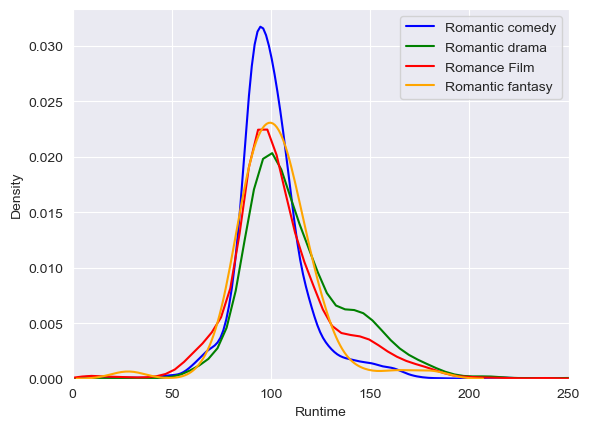

In [15]:
ax = sns.kdeplot(romantic_comedy['Runtime'], color='blue')
ax = sns.kdeplot(romantic_drama['Runtime'], color='green')
ax = sns.kdeplot(romantic_film['Runtime'], color='red')
ax = sns.kdeplot(romantic_fantasy['Runtime'], color='orange')
ax.set_xlim(0,250)
ax.legend(['Romantic comedy', 'Romantic drama', 'Romance Film', 'Romantic fantasy'])


### 3.3. Romantic movies box office revenue

In [16]:
#Does not give a good view
#combined_box_office = pd.DataFrame({'Romantic comedy': romantic_comedy['Box office revenue'], 'Romance Film': romantic_film['Box office revenue'], 'Romantic drama': romantic_drama['Box office revenue'], 'Romantic fantasy': romantic_fantasy['Box office revenue']})
#sns.boxplot(combined_box_office)

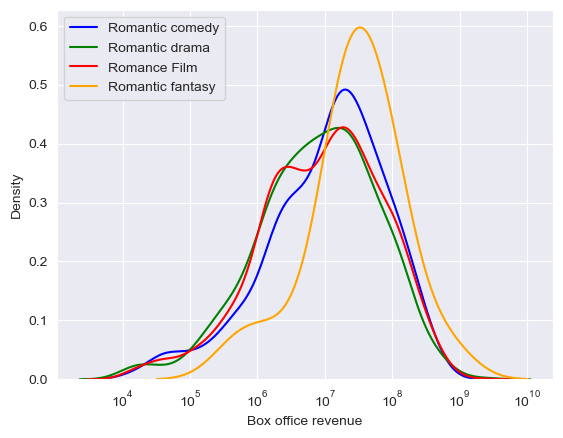

In [17]:
ax = sns.kdeplot(romantic_comedy['Box office revenue'], log_scale=True, color='blue')
ax = sns.kdeplot(romantic_drama['Box office revenue'], log_scale=True, color='green')
ax = sns.kdeplot(romantic_film['Box office revenue'], log_scale=True, color='red')
ax = sns.kdeplot(romantic_fantasy['Box office revenue'], log_scale=True, color='orange')
ax.legend(['Romantic comedy', 'Romantic drama', 'Romance Film', 'Romantic fantasy'])


### 3.4. Romantic movies countries

In [18]:
get_countries = lambda x: len(x) if type(x) == list else np.nan
romantic_comedy['number_countries'] = romantic_comedy['Countries'].apply(get_countries)
romantic_fantasy['number_countries'] = romantic_fantasy['Countries'].apply(get_countries)
romantic_film['number_countries'] = romantic_film['Countries'].apply(get_countries)
romantic_drama['number_countries'] = romantic_drama['Countries'].apply(get_countries)

combined_numb_countries = pd.DataFrame({
    'Romantic comedy': romantic_comedy['number_countries'], 
    'Romance Film': romantic_film['number_countries'], 
    'Romantic drama': romantic_drama['number_countries'], 
    'Romantic fantasy': romantic_fantasy['number_countries']})

print('Percentage romantic comedy movie countries > 1: ', round(romantic_comedy[romantic_comedy['number_countries']> 1].shape[0]/romantic_comedy.shape[0], 2), '%')
print('Other countries can be added in code...')

Percentage romantic comedy movie countries > 1:  0.14 %
Other countries can be added in code...


C:\Users\alexs\AppData\Local\Temp\ipykernel_14668\3260151978.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  romantic_comedy['number_countries'] = romantic_comedy['Countries'].apply(get_countries)
C:\Users\alexs\AppData\Local\Temp\ipykernel_14668\3260151978.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  romantic_fantasy['number_countries'] = romantic_fantasy['Countries'].apply(get_countries)
C:\Users\alexs\AppData\Local\Temp\ipykernel_14668\3260151978.py:4: SettingWithCopyWarning: 
A value is tryin

### 3.5. Movie languages

In [19]:
#Get languages whole movie set
movies_language = movie_df[movie_df['Languages'].notnull()]
languages=movies_language['Languages'].sum()
values, counts = np.unique(languages, return_counts=True)
print('5 most common languages in movies are: ')
print(values[counts.argsort()[-5:][::-1]])

#Get languages romantic movies overall
romance_movies_lang = romance_movies[romance_movies['Languages'].notnull()]
languages_romance = romance_movies_lang.Languages.sum()
values, counts = np.unique(languages_romance, return_counts=True)
print('\n5 most common languages in romantic movies: ')
print(values[counts.argsort()[-5:][::-1]])


rom_com_known = romantic_comedy[romantic_comedy['Languages'].notnull()]
languages_romcom = rom_com_known.Languages.sum()
values, counts = np.unique(languages_romcom, return_counts=True)
print('\n5 most common languages in romantic comedies: ')
print(values[counts.argsort()[-5:][::-1]])

5 most common languages in movies are: 
['English' 'Hindi' 'Spanish' 'French' 'Silent film']

5 most common languages in romantic movies: 
['English' 'Hindi' 'French' 'Tamil' 'Spanish']

5 most common languages in romantic comedies: 
['English' 'French' 'Hindi' 'Spanish' 'Italian']


## Evolution over time

In [23]:
# Isolate the year from the release date
getYear = lambda x: x[0:4] if type(x) == str else x
movie_df['Release date'] = movie_df['Release date'].apply(getYear)
romance_movies['Release date'] = romance_movies['Release date'].apply(getYear)

C:\Users\alexs\AppData\Local\Temp\ipykernel_14668\3470513930.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  romance_movies['Release date'] = romance_movies['Release date'].apply(getYear)


### Box office revenue over time

C:\Users\alexs\AppData\Local\Temp\ipykernel_14668\1021648461.py:9: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  plt.locator_params(nbins=10)


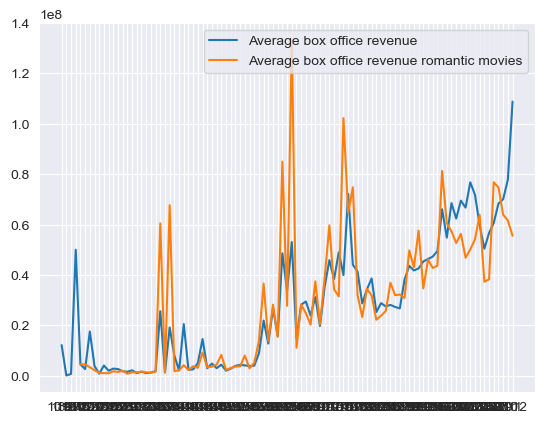

In [54]:
import matplotlib.pyplot as plt
year_box_office = movie_df[['Release date', 'Box office revenue']].dropna()
year_box_office_romance = romance_movies[['Release date', 'Box office revenue']].dropna()
yearly_revenue_total = year_box_office.groupby('Release date').mean()
yearly_revenue_romance = year_box_office_romance.groupby('Release date').mean()
plt.plot(yearly_revenue_total.index, yearly_revenue_total['Box office revenue'], label = 'Average box office revenue')
plt.plot(yearly_revenue_romance.index, yearly_revenue_romance['Box office revenue'], label= 'Average box office revenue romantic movies')
plt.legend()
plt.locator_params(nbins=10)
plt.show()

### 3.5. CoreNLP Plot summaries

`corenlp_plot_summaries.tar.gz [628 M, separate download]`: The plot summaries from above, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).

In [ ]:
#TODO: only consider romantic movies
import xml.etree.ElementTree as ET
extracted_dir = 'Data/CoreNLP/corenlp_plot_summaries_xml'

def make_pairs (extracted_dir): 
  pairs = []
  for filename in os.listdir(extracted_dir):
      f = os.path.join(extracted_dir, filename) 
      if os.path.isfile(f):
          # Create characters list for each file 
          characters = []
          tree = ET.parse(f)
          root = tree.getroot()
          for child in tree.iter():
              if child.tag == "word":
                current_word = child.text
              if child.tag == "NER": 
                if child.text == "PERSON":
                  characters.append(current_word)
          # Select the two characters which appear most often in the file
          values, counts = np.unique(characters, return_counts=True)
          two_most_frequent_characters = values[counts.argsort()[-2:][::-1]]
          # If there exists two characters, create a pair 
          if len(two_most_frequent_characters) > 1:
            pairs.append([f.replace('Data/CoreNLP/corenlp_plot_summaries_xml/', '').replace('.xml', ''), two_most_frequent_characters[0], two_most_frequent_characters[1]])
  return pairs

# Convert into an array and as a dataframe
pairs = make_pairs(extracted_dir)
pairs = np.asarray(pairs).reshape(-1, 3)  
pairs_df = pd.DataFrame(pairs, columns=['Wikipedia ID', 'char1', 'char2']) 
pairs_df                                     

In [ ]:
# Merge pairs dataset with characters 
char_df['Wikipedia ID'] = char_df['Wikipedia ID'].astype(str)
pairs_df['Wikipedia ID'] = pairs_df['Wikipedia ID'].astype(str)
pairs_char = pairs_df.merge(char_df, on="Wikipedia ID")

# Filter out the nan values
pairs_char = pairs_char[~pairs_char['Character name'].isna()]

# Create columns which indicates if char1 and char2 are in character name 
pairs_char['char1_is_in_name'] = pairs_char.apply(lambda x: 1 if x['char1'] in x['Character name'] else 0, axis=1)
pairs_char['char2_is_in_name'] = pairs_char.apply(lambda x: 1 if x['char2'] in x['Character name'] else 0, axis=1)
pairs_char[pairs_char['char1_is_in_name'] == 1 & pairs_char['char2_is_in_name'] == 1]

In [ ]:
# To print xml files as a pretty tree
import xml.dom.minidom

def print_tree_xml(xml_name):
    tree_xml = xml.dom.minidom.parse(xml_name).toprettyxml()
    print(tree_xml)

#print_tree_xml('Data/CoreNLP/corenlp_plot_summaries_xml/3217.xml')

For any character, we want to extract related information (from name clusters, character metadata) as well as actions, characteristics and relations (from CoreNLP). 

In [ ]:
char_df

In [ ]:
# For any character in char_df, get the wikipedia movie ID
def get_character_data(char_name):
    movie_ids = list(char_df[char_df['Character name'] == 'Harry Potter'].index)
    # Get cluster of character from name_clusters
    cluster = name_clusters[char_name]
char_name = 
get_wiki_movie_id('Harry Potter')


We would like to identify the two main characters in a plot summary. 


## 4. An Analysis of Romance




### 4.1. ?

### 4.2. ?

### 4.3. ?